# Tangles-CNN Training Notebook with Bounding Boxes

In [1]:
# System imports
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
import json
from PIL import Image
import pandas as pd

# Import modified wildcat
sys.path.append("../tangle-cnn-prod/")
sys.path.append("../tangle-cnn-prod/wildcat_pytorch")
from picsl_wildcat import util, models, losses, gmm

# Print basic stats
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117
CUDA status:  True
CUDA memory max alloc:        0 MB


## User parameters
Modify data location and parameters below to your specifications

In [2]:
# Top level data directory. Replace with the directory containing the output of organize_samples.sh 
# The directory must conform to the PyTorch ImageFolder structure
exp_dir = "/data/pauly2/wildcat/data/thon2019/exp02_multiclass"

# Load the manifest file, which has the bounding box sizes 
manifest_file = "/data/pauly2/wildcat/data/thon2019/manifest_2023.csv"

# Create a config object - this gets saved along with the model after training
# Please see Durand CVPR 2018 (WildCat paper) for meaning of kmin, kmax, alpha, num_maps
# The parameter "bounding_box" specifies whether a bounding box is used to limit the
# loss calculation to the box drawn by the user rather than whole patch. Good when users
# draw small boxes around inclusions.
config = {
    "wildcat_upsample": {
        "kmax": 0.02,
        "kmin": 0.0,
        "alpha": 0.7,
        "num_maps": 2,
        "input_size": 224,
        "num_epochs": 30,
        "batch_size": 30,
        "bounding_box": True,
        "bounding_box_min_size": 112
    }
}

In [3]:
# Define useful variables 
bs = config['wildcat_upsample']['batch_size']

## Dataloaders and Transforms

In [4]:
# Patch directory
data_dir = os.path.join(exp_dir, "patches")

# Transforms for training and validation
input_size = config['wildcat_upsample']['input_size']

# Custom transforms to apply
data_transforms = {
    'train': transforms.Compose([
        util.ColorJitterRGB(0.0, 0.0, 0.2, 0.2),
        util.NormalizeRGB([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        util.RandomCrop(input_size),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip()
    ]),
    'val': transforms.Compose([
        util.NormalizeRGB([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.CenterCrop(input_size)
    ]),
}


# Training and validation dataloaders
manifest = pd.read_csv(manifest_file) if config['wildcat_upsample']['bounding_box'] is True else None

# Custom dataset object that generates masks from bounding boxes if needed
image_datasets = {
    x: util.ImageFolderWithBBox(
        os.path.join(data_dir, x), 
        manifest, 
        data_transforms[x],
        config['wildcat_upsample']['bounding_box_min_size']) 
    for x in ['train', 'val']
}

# Custom dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=bs,
        shuffle=True, num_workers=4) 
    for x in ['train', 'val']
}

# Get class information 
class_to_index = image_datasets['train'].class_to_idx
cnames = {v:k for k,v in class_to_index.items() }
n_classes = len(class_to_index)

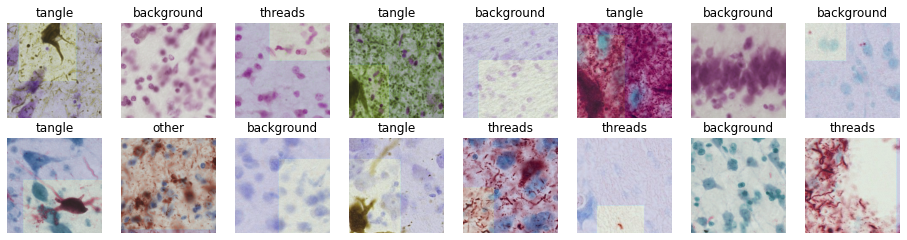

In [5]:
# Read a batch of data from the training data loader
img,label=next(iter(dataloaders['train']))
plt.figure(figsize=(16,6))
util.show_patches_with_masks(img, label, cnames, 8, 0.1, 2)

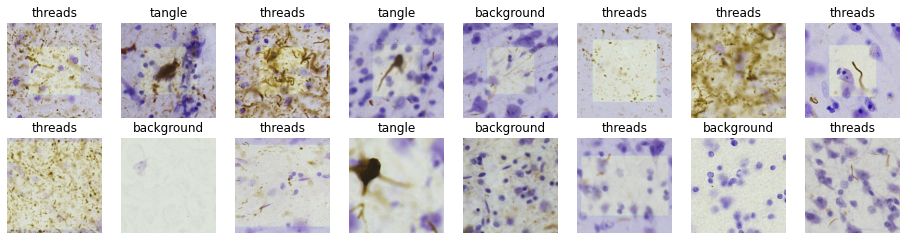

In [6]:
# Also show a batch from the validation model
imgv,labelv=next(iter(dataloaders['val']))
plt.figure(figsize=(16,6))
util.show_patches_with_masks(imgv, labelv, cnames, 8, 0.1, 2)

## Instantiate model

In [7]:
# Instantiate WildCat model
config['num_classes'] = n_classes

#model=models.resnet50_wildcat_upsample(
#    config['num_classes'], 
#    pretrained=True, 
#    kmax=config['wildcat_upsample']['kmax'], 
#    kmin=config['wildcat_upsample']['kmin'],
#    alpha=config['wildcat_upsample']['alpha'], 
#    num_maps=config['wildcat_upsample']['num_maps'])

model = gmm.UNet_WSL_GMM(
    num_classes = config['num_classes'],
    mix_per_class=config['wildcat_upsample']['num_maps'], 
    kmax=config['wildcat_upsample']['kmax'], 
    kmin=config['wildcat_upsample']['kmin'],
    alpha=config['wildcat_upsample']['alpha'],
    fu_blocks=2, fu_dim=5, mode='gmm')

# Wrap the model as a bounding box model
# model = models.BoundingBoxWildCatModel(model, 0.5)
model = models.BoundingBoxWildCatModel(model, 1)

# Loss and optimizer
# criterion = nn.MultiLabelSoftMarginLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-2)

# We use BCE loss because network outputs are probabilities, and this loss
# does log clamping to prevent infinity or NaN in the gradients
# criterion = torch.nn.BCELoss()

# Use the loss that accounts for presence of threads in tangle patches, background in all patches
criterion = losses.TanglethonLoss(torch.tensor([
    [0,  1/3, 1/3, 1/3],
    [0,  0,   1,   0  ],
    [0,  1,   0,   0  ],
    [0,  1/2, 1/2, 0  ]]))

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-2)

In [8]:
# Map model and criterior to device
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

model = model.to(device)
criterion = criterion.to(device)

Device:  cuda:0


In [9]:
# Try the model on one minibatch
with torch.set_grad_enabled(False):
    x = img.to(device)
    z = model(x)

z

tensor([[0.1774, 0.3434, 0.1931, 0.1885],
        [0.3939, 0.4656, 0.4028, 0.2633],
        [0.3125, 0.3716, 0.4325, 0.1976],
        [0.1311, 0.2031, 0.2296, 0.2191],
        [0.1620, 0.1831, 0.1924, 0.1619],
        [0.2349, 0.2239, 0.2870, 0.3001],
        [0.4768, 0.4978, 0.3400, 0.4360],
        [0.1776, 0.1736, 0.2667, 0.1823],
        [0.2989, 0.2393, 0.2251, 0.4360],
        [0.2988, 0.4025, 0.1436, 0.3053],
        [0.3088, 0.1948, 0.3041, 0.3390],
        [0.1969, 0.1931, 0.1900, 0.3050],
        [0.1873, 0.2257, 0.1346, 0.1570],
        [0.2364, 0.2120, 0.2434, 0.1917],
        [0.2700, 0.2084, 0.3755, 0.4658],
        [0.2711, 0.2917, 0.3548, 0.2239],
        [0.4679, 0.4990, 0.4398, 0.4855],
        [0.2881, 0.3066, 0.1342, 0.2036],
        [0.3034, 0.4011, 0.3510, 0.3114],
        [0.2382, 0.2891, 0.2814, 0.2344],
        [0.3493, 0.2460, 0.3153, 0.4366],
        [0.3651, 0.3129, 0.3934, 0.4970],
        [0.2125, 0.3103, 0.1282, 0.1847],
        [0.2365, 0.2495, 0.4057, 0

In [10]:
# Standard training code
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            nmb = len(dataloaders[phase])
            for mb, (inputs, labels) in enumerate(dataloaders[phase]):
                
                # Split out the image and mask portion of the inputs
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels_one_hot = torch.zeros([labels.shape[0], n_classes])
                for i in range(n_classes):
                    labels_one_hot[:, i] = (labels == i)
                labels_one_hot = labels_one_hot.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels_one_hot)
                    preds = criterion.predictions(outputs)
                    # _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # Print minibatch stats
                    # print('MB %04d/%04d  loss %f  corr %d  minbox %d' %
                    #       (mb, nmb, loss.item(), torch.sum(preds == labels.data).item(),
                    #       int((mask_interp > 0).sum(2).sum(2).min())))

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print('MB %04d  loss %f  corr %d' % (mb, loss.item(), torch.sum(preds == labels.data).item()))
                # print('.', end='')
                sys.stdout.flush()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print()
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [11]:
# Train and evaluate
model_ft, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=config['wildcat_upsample']['num_epochs'])

Epoch 0/29
----------
MB 0000  loss 1.403872  corr 5
MB 0001  loss 1.399714  corr 8
MB 0002  loss 1.406820  corr 8
MB 0003  loss 1.397511  corr 8
MB 0004  loss 1.411312  corr 8
MB 0005  loss 1.404378  corr 8
MB 0006  loss 1.407134  corr 6
MB 0007  loss 1.404455  corr 8
MB 0008  loss 1.389251  corr 12
MB 0009  loss 1.399411  corr 9
MB 0010  loss 1.381251  corr 10
MB 0011  loss 1.394758  corr 8
MB 0012  loss 1.380860  corr 14
MB 0013  loss 1.387471  corr 11
MB 0014  loss 1.381029  corr 13
MB 0015  loss 1.384238  corr 13
MB 0016  loss 1.374225  corr 12
MB 0017  loss 1.381593  corr 10
MB 0018  loss 1.383169  corr 11
MB 0019  loss 1.393155  corr 6
MB 0020  loss 1.384817  corr 7
MB 0021  loss 1.368191  corr 14
MB 0022  loss 1.386539  corr 9
MB 0023  loss 1.370959  corr 14
MB 0024  loss 1.365624  corr 14
MB 0025  loss 1.358135  corr 19
MB 0026  loss 1.365847  corr 9
MB 0027  loss 1.351005  corr 16
MB 0028  loss 1.362059  corr 14
MB 0029  loss 1.352275  corr 18
MB 0030  loss 1.355924  corr 14


## Test model on a batch of data

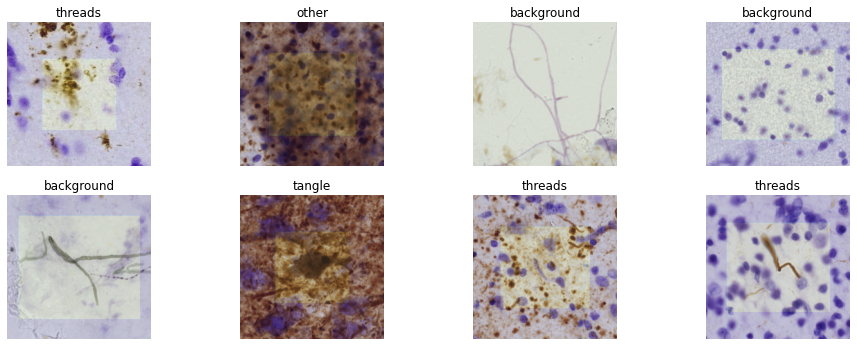

In [12]:
mb, (inputs, labels) = next(enumerate(dataloaders['val']))
plt.figure(figsize=(16,9))
util.show_patches_with_masks(inputs.cpu(), labels.cpu(), cnames, 4, 0.1, 2)

In [15]:
with torch.set_grad_enabled(False):
    y0 = model.wildcat_model.softmax(model.wildcat_model.unet(inputs[:,:3,:,:].to(device)))
    y1 = model.wildcat_model.forward_to_classifier(inputs[:,:3,:,:].to(device))
    y2 = model.wildcat_model.spatial_pooling.class_wise.forward(y1)
    preds = criterion.predictions(model_ft(inputs.to(device)))

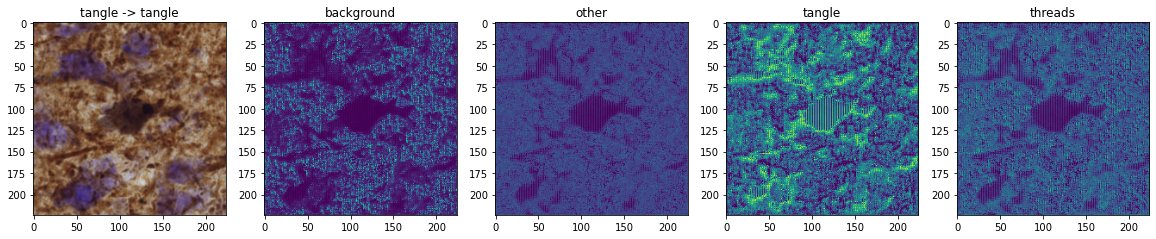

In [17]:
plt.figure(figsize=(20,4))
k = 5
sel = y2[k,:,:,:]
plt.subplot(1,5,1)
plt.imshow(((2.2+inputs[k,0:3,:,:].permute(1,2,0).detach().cpu().numpy()) / 5), vmin=0, vmax=1);
plt.title('%s -> %s' % (cnames[labels[k].data.item()],cnames[preds[k].item()]))
for i in range(4):
    plt.subplot(1,5,i+2)
    plt.imshow(sel[i,:,:].detach().cpu().numpy(), vmin=torch.min(sel), vmax=torch.max(sel).item());
    plt.title('%s' % (cnames[i],))
    # plt.title('%s (%6.4f)' % (cnames[i], res[k,i].item()))

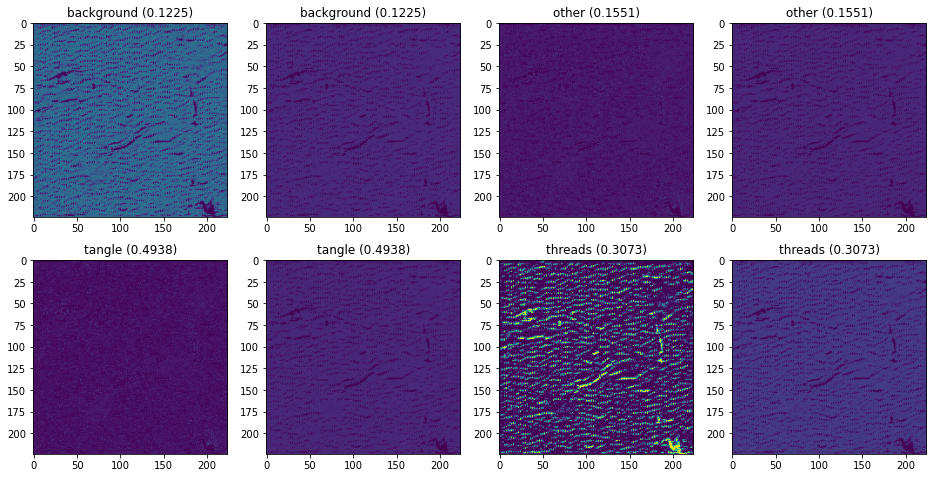

In [111]:
plt.figure(figsize=(16,8))
sel = y1[k,:,:,:]
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(sel[i,:,:].detach().cpu().numpy(), vmin=torch.min(sel), vmax=torch.max(sel).item());
    plt.title('%s (%6.4f)' % (cnames[i//2], res[k,i//2].item()))

In [100]:
with torch.set_grad_enabled(False):
    q0 = model.wildcat_model.feature_unet.down_blocks[0](inputs[:,:3,:,:].to(device))
    q1 = model.wildcat_model.feature_unet.conv_final(q0[0])

In [102]:
q1.shape

torch.Size([30, 5, 224, 224])

## Export model

In [16]:
# Save the model using a format that can be read using production-time scripts
model_dir = os.path.join(exp_dir, "models_boxexp")
os.makedirs(model_dir, exist_ok=True)

# Save the model
torch.save(model_ft.wildcat_model.state_dict(), os.path.join(model_dir, "wildcat_upsample.dat"))

# Save the configuration
config['class_to_idx'] = class_to_index
with open(os.path.join(model_dir, 'config.json'), 'w') as jfile:
    json.dump(config, jfile)

Task was destroyed but it is pending!
task: <Task pending name='Task-2' coro=<Kernel.poll_control_queue() running at /home/pauly2/.conda/envs/be537/lib/python3.9/site-packages/ipykernel/kernelbase.py:227> wait_for=<Future finished result=[<zmq.sugar.fr...x7f4798533720>, <zmq.sugar.fr...x7f479808deb0>, <zmq.sugar.fr...x7f47981ec460>, <zmq.sugar.fr...x7f4791887930>, <zmq.sugar.fr...x7f4887a3e0f0>, <zmq.sugar.fr...x7f479858bd50>, ...]> cb=[_chain_future.<locals>._call_set_state() at /home/pauly2/.conda/envs/be537/lib/python3.9/asyncio/futures.py:391]>


Model performance over epochs

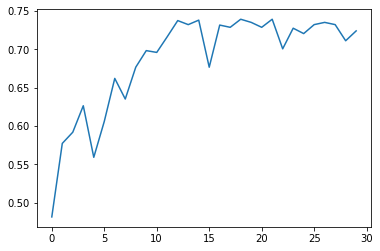

In [13]:
plt.plot([x.item() for x in hist])

# Run model with additional contrastive loss

In [10]:
# Load the state dict of the wrapped model
model_dir = os.path.join(exp_dir, "models_boxexp")
model.wildcat_model.load_state_dict(
    torch.load(os.path.join(model_dir, "wildcat_upsample.dat")))

<All keys matched successfully>

In [11]:
# Standard training code
def train_model_contrastive(model, dataloaders, criterion, optimizer, num_epochs=25, wcon=0.1):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    c_criterion = losses.SegmentationContrastiveLoss()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_a_loss = 0.0
            running_c_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            nmb = len(dataloaders[phase])
            for mb, (inputs, labels) in enumerate(dataloaders[phase]):
                
                # Split out the image and mask portion of the inputs
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels_one_hot = torch.zeros([labels.shape[0], n_classes])
                for i in range(n_classes):
                    labels_one_hot[:, i] = (labels == i)
                labels_one_hot = labels_one_hot.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    a_loss = criterion(outputs, labels_one_hot)
                    _, preds = torch.max(outputs, 1)

                    # Get the per-class activation maps (this is wasteful, the model has been run already)
                    cw_act = model.wildcat_model.forward_to_classifier(inputs[:,:3,:,:])
                    
                    # Convert them to probabilities
                    cw_prob = torch.nn.functional.softmax(cw_act, 1)
                    
                    # Compute the loss on RGB data
                    rgb = torch.nn.functional.interpolate(inputs[:,:3,:,:], scale_factor=0.5, mode='bilinear',align_corners=False)
                    c_term = c_criterion(rgb, cw_prob)
                    
                    # Avererage the loss and scale by a weight
                    c_loss = torch.mean(c_term)
                    loss = a_loss + c_loss * wcon
                                        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # Print minibatch stats
                    # print('MB %04d/%04d  loss %f  corr %d  minbox %d' %
                    #       (mb, nmb, loss.item(), torch.sum(preds == labels.data).item(),
                    #       int((mask_interp > 0).sum(2).sum(2).min())))

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_a_loss += a_loss.item() * inputs.size(0)
                running_c_loss += c_loss.item() * inputs.size(0);
                running_corrects += torch.sum(preds == labels.data)
                print('.', end='')
                sys.stdout.flush()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_a_loss = running_a_loss / len(dataloaders[phase].dataset)
            epoch_c_loss = running_c_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print()
            print('{} ALoss: {:.4f} CLoss: {:.4f} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_a_loss, epoch_c_loss, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    ## model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [13]:
model_ft, hist = train_model_contrastive(model, dataloaders, criterion, optimizer, num_epochs=200, wcon=0.1)

Epoch 0/199
----------
.............................................................................
train ALoss: 0.1521 CLoss: 2.9762 Loss: 0.4498 Acc: 0.9114
...................................
val ALoss: 0.2021 CLoss: 2.9196 Loss: 0.4940 Acc: 0.8710

Epoch 1/199
----------
.............................................................................
train ALoss: 0.1474 CLoss: 2.9269 Loss: 0.4401 Acc: 0.9182
...................................
val ALoss: 0.1896 CLoss: 2.8789 Loss: 0.4775 Acc: 0.8780

Epoch 2/199
----------
.............................................................................
train ALoss: 0.1432 CLoss: 2.8996 Loss: 0.4331 Acc: 0.9208
...................................
val ALoss: 0.1895 CLoss: 2.8816 Loss: 0.4777 Acc: 0.8675

Epoch 3/199
----------
.............................................................................
train ALoss: 0.1446 CLoss: 2.8884 Loss: 0.4334 Acc: 0.9200
...................................
val ALoss: 0.1922 CLoss: 2.8292 Loss: 0.47

# Play with Cmeans

In [13]:
mb, (inputs, labels) = next(enumerate(dataloaders['train']))

In [127]:
inputs = inputs.to(device)
labels = labels.to(device)
labels_one_hot = torch.zeros([labels.shape[0], n_classes])
for i in range(n_classes):
    labels_one_hot[:, i] = (labels == i)
labels_one_hot = labels_one_hot.to(device)

# zero the parameter gradients
optimizer.zero_grad()

c_loss = losses.SegmentationContrastiveLoss()

In [151]:
with torch.set_grad_enabled(False):
    # Get model outputs and calculate loss
    outputs = model(inputs)
    loss = criterion(outputs, labels_one_hot)
    _, preds = torch.max(outputs, 1)

    # Get the per-class activation maps (this is wasteful, the model has been run already)
    cw_act = model.wildcat_model.forward_to_classifier(inputs[:,:3,:,:])

    # Convert them to probabilities
    cw_prob = torch.nn.functional.softmax(cw_act, 1)

    # Compute the loss on RGB data
    rgb = torch.nn.functional.interpolate(inputs[:,:3,:,:], scale_factor=0.5, mode='bilinear',align_corners=False)
    c_term = c_loss(rgb, cw_prob)

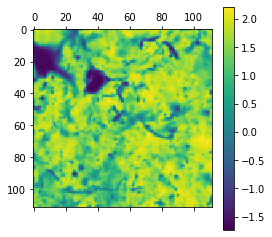

In [152]:
plt.matshow(rgb[2,2,:,:].detach().cpu().numpy())
plt.colorbar()

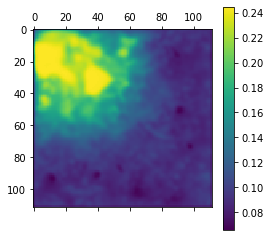

In [153]:
plt.matshow(cw_prob[2,8,:,:].cpu().detach().numpy())
plt.colorbar()

In [194]:
c_means = torch.einsum('bkij,bcij->bkc',cw_prob,rgb) / torch.einsum('bkij->bk',cw_prob).unsqueeze(-1)
c_sqdev = torch.sum((rgb.unsqueeze(1) - c_means.unsqueeze(-1).unsqueeze(-1))**2, axis=2)
cw_prob = (torch.sum(c_sqdev**-1, axis=1).unsqueeze(1) * c_sqdev)**-1
torch.sum((cw_prob**2) * c_sqdev).item()

20870.98046875

In [157]:
c_sqdev.shape

torch.Size([50, 16, 112, 112])

In [181]:
torch.sum((cw_prob**2) * c_sqdev)

tensor(127778.9062, device='cuda:0')

In [110]:
torch.einsum('bkij,bmij->

tensor([0.6075, 0.3412, 0.1345], device='cuda:0')

In [165]:
cw_prob[2,:,20,12]

tensor([0.0006, 0.0006, 0.0007, 0.0006, 0.0009, 0.0009, 0.0009, 0.0009, 0.2444,
        0.2572, 0.2436, 0.2448, 0.0009, 0.0010, 0.0009, 0.0011],
       device='cuda:0')

In [174]:
(torch.sum(c_sqdev[2,:,20,12]**-1, axis=0) * c_sqdev[2,:,20,12])**-1

tensor([0.0586, 0.0586, 0.0586, 0.0586, 0.0601, 0.0600, 0.0600, 0.0600, 0.0717,
        0.0721, 0.0722, 0.0721, 0.0593, 0.0593, 0.0593, 0.0593],
       device='cuda:0')

In [179]:
((torch.sum(c_sqdev**-1, axis=1).unsqueeze(1) * c_sqdev)**-1)[2,:,20,12]

tensor([0.0586, 0.0586, 0.0586, 0.0586, 0.0601, 0.0600, 0.0600, 0.0600, 0.0717,
        0.0721, 0.0722, 0.0721, 0.0593, 0.0593, 0.0593, 0.0593],
       device='cuda:0')

In [178]:
torch.sum(c_sqdev**-1, axis=1).shape

torch.Size([50, 112, 112])

In [166]:
(c_sqdev[2,:,20,12] * torch.sum(c_sqdev[2,:,20,12]**-1))**-1

tensor([0.0586, 0.0586, 0.0586, 0.0586, 0.0601, 0.0600, 0.0600, 0.0600, 0.0717,
        0.0721, 0.0722, 0.0721, 0.0593, 0.0593, 0.0593, 0.0593],
       device='cuda:0')

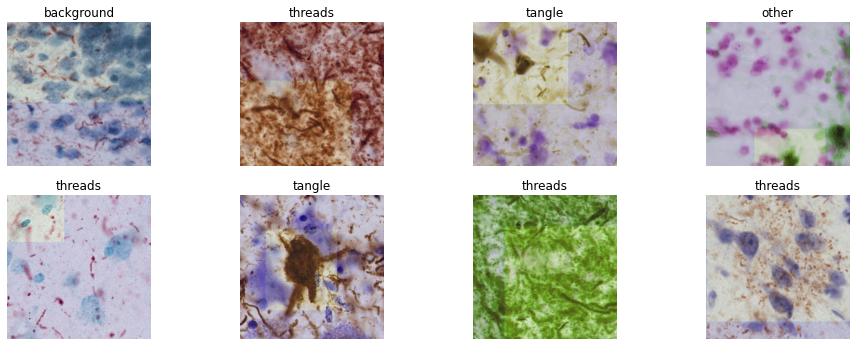

In [25]:
plt.figure(figsize=(16,9))
util.show_patches_with_masks(inputs.cpu(), labels.cpu(), cnames, 4, 0.1, 2)

In [29]:
plt.matshow(c_term.detach().cpu().numpy())

ValueError: not enough values to unpack (expected 2, got 1)